In [1]:
import numpy as np 
import pandas as pd
from collections import defaultdict 
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=12)

In [2]:
# All courses have 12 weeks, 2 days a week
# To simplify, we will assume months with 28 days and will disconsider weekends
days = range(1, 29)
# Each term lasts three months and these months are always fixed
terms = [[2,3,4], [6,7,8], [10,11,12]]
years = [2021, 2022, 2023]

In [3]:
# parameters
numStudents = 300
courses = 200

In [10]:
# Info for each day of the calendar

# estimated from SP averages taken from https://www.climatestotravel.com/climate/brazil                             
weather = [(1, 0, 0), (0, 1, 0), (0, 0, 1)] # sunny, rainy, cloudy 

# Probability of raining is the avg. number of rainy days for each month divided by 30 days 
rainProb = { (k+1):(v/30) for k, v in enumerate([18,16,13,9,9,6,7,7,9,11,13,16]) }
# sunny and cloudy probabilities are 80% and 20% of the remaining probability of rain
sunProb = { k : (1 - v)*0.8 for k, v in rainProb.items() }
cloudProb = { k : (1 - v)*0.2 for k, v in rainProb.items() }
# avg. and std. of mm of rain, it is divided by 15 as an average number of rainy days
qtyRain = { (k+1):(v/60) for k, v in enumerate([240, 215, 160, 75, 75, 55, 45, 40, 80, 125, 145, 200]) }
rateRain = { (k+1):v for k, v in enumerate([7, 7, 6, 4, 4, 3, 3, 3, 4, 5, 5, 5]) }

In [11]:
dict_days = {}
monthTerm = {2:0, 3:1, 4:2, 6:0, 7:1, 8:2, 10:0, 11:1, 12:2}
dates = [(year, month, day) for year in years for term in terms for month in term for day in days]
for year, month, day in dates:
    date = f"{year}-{month}-{day}"
    # sample whether it is sunny, rainy or cloudy depending on the probabilities of the month
    (isSunny, isRainy, isCloudy) = rng.choice(weather, p=[sunProb[month], rainProb[month], cloudProb[month]])
    # calculate the week of the month
    week = (day-1) // 7 + monthTerm[month]*4 + 1
    # if it is rainy, it will rain at least 2mm or a random value around the month average and std. following a normal dist.
    mmRain = rng.gamma(qtyRain[month], rateRain[month]) if isRainy else 0
    dict_days[date] = [week, isSunny, isRainy, isCloudy, mmRain]
df_days = pd.DataFrame.from_dict(dict_days, orient='index', columns=['week', 'isSunny', 'isRainy', 'isCloudy', 'mmRain'])
df_days.to_csv("days_info.csv")

<Axes: >

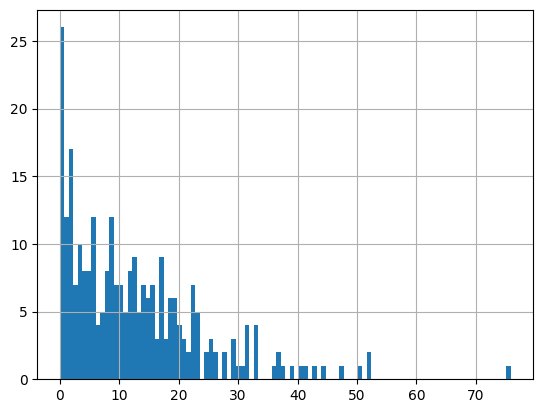

In [12]:
df_days[(df_days.mmRain > 0)]['mmRain'].hist(bins=100)

In [7]:
# Student info 

# the number of children follows a power distribution with
# exponent equals to the log of age - 3, as the age ranges from [27, 43]
# ln(age) ~ 3.xx, the power distribution will increase the number of children 
# at every additional year
def getChildren(age):
    return np.round(rng.power(np.log(age)-3,1)*5)[0]
# enoll time in months is a random distribution around age - 23
# it should range between [4, 20] months +/- 14 months
def getEnroll(age):
    return rng.poisson(age - 23) # np.max([np.round(rng.normal(age - 23, 7)), 1])
# has work folows a binomial distribution from the logistic expression 
# dependent of age
def hasWork(age):
    p = 1 / (1 + np.exp(-0.2*(age-25)))
    return rng.binomial(1, p)
# the older the student the higher the probability of not being single
def single(age):
    p = 1 / (1 + np.exp(-0.15*(age-25)))
    return rng.binomial(1, 1 - p)


In [8]:
# age is sampled from a poisson with mean = 4, this will generate a value between [0, inf] with a higher 
# probability around 4. We will add 25 so we will have ages starting at 25.
ages = rng.poisson(4, numStudents) + 25
# apply each supporting function to the list of ages
numChildren = list(map(getChildren, ages))
enrollmentTime = list(map(getEnroll, ages))
distance = rng.poisson(18, numStudents)
works = list(map(hasWork, ages))
isSingle = list(map(single, ages))
df_students = pd.DataFrame.from_dict({'age' : ages, 'numChildren' : numChildren, 'enrollmentTime' : enrollmentTime, 'distance' : distance, 'work':works, 'isSingle':isSingle})
df_students.to_csv('students.csv')

<Figure size 1000x1000 with 0 Axes>

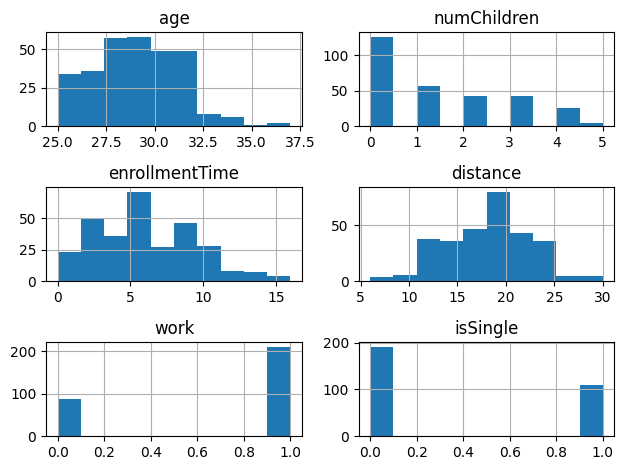

In [9]:
plt.figure(figsize=(10,10))
df_students.hist()
plt.tight_layout()

In [10]:
# supporting functions to generate the avg. speed of a specific day given a student info                            
# the avg. speed is normally distributed around a mean that depends on weather condition and student info 
def sampleSpeed(dayInfo, studentInfo):
    return np.max([10, rng.normal(40 + 5*dayInfo.isSunny - 5*dayInfo.isRainy - np.exp(0.2*dayInfo.mmRain) + 5*studentInfo.isSingle - 2*studentInfo.numChildren - 2*studentInfo.isSingle*studentInfo.numChildren, 5)])
# the attendance  of a student at an specific date depends on the weather condition and ETA 
# having an exam increases the probability of attendance
def sampleAttend(dayInfo, studentInfo, ETA, hours, exam):
    y = (16.1 + 11.5*exam - 1.3*np.exp(0.4*hours) - 1.1*np.exp(0.3*ETA) - 3.2*studentInfo.numChildren)
        /(1 + 15.2*dayInfo.mmRain + 21.3*studentInfo.numChildren*dayInfo.isRainy)
    return rng.binomial(1, 1/(1 + np.exp(-y)))


In [11]:
ix = 0
record = {}
final_day = {}
# for each course
for course in range(courses):
    # pick an year, term and fst and snd days
    year = rng.choice(years)
    term = rng.choice(terms)
    fstDay = rng.choice([1,2,3])
    sndDay = rng.choice(range(fstDay+1, 8))
    dates = [f"{year}-{month}-{day}" for day in [fstDay, sndDay, fstDay + 7, sndDay + 7, fstDay + 14, sndDay + 14, fstDay + 21, sndDay + 21] for month in term]

    # pick 40 students at random without replacement
    students = rng.choice(numStudents, 40, replace=False)

    # att will count the attendance so far
    att = defaultdict(int)
    # the final day of this course will contain the final grade
    final_day[course] = sndDay + 21

    for date in dates:
        for student in students:
            day = int(date.split("-")[2])
            hasExam = 1 if day == fstDay + 21 or day == sndDay + 14 else 0
            finalGrade = 0.0

            speed = sampleSpeed(df_days.loc[date], df_students.iloc[student])
            ETA = df_students.iloc[student].distance / speed 
            # work hours, if the student works, is a normal distribution around 4 +/- 1.6
            # multinomial 4,8,10?
            hoursWork = [2,4,6,8][np.argmax(rng.multinomial(1, [0.1, 0.4, 0.3, 0.2]))] if df_students.iloc[student].work else 0
            hasAttended = sampleAttend(df_days.loc[date], df_students.iloc[student], ETA, hoursWork, hasExam)
            numAttendence = att[student]
            att[student] += hasAttended
            ix += 1 
            record[ix] = [course, date, student, hasAttended, ETA, hasExam, numAttendence, hoursWork, finalGrade]
df_attendance = pd.DataFrame.from_dict(record, orient='index', columns=['course', 'date', 'student', 'hasAttended', 'ETA', 'hasExam', 'numAttendence', 'hoursWork', 'finalGrade'])
df_attendance.to_csv('attendance.csv')

array([[<Axes: title={'center': 'hasAttended'}>,
        <Axes: title={'center': 'ETA'}>],
       [<Axes: title={'center': 'numAttendence'}>,
        <Axes: title={'center': 'hoursWork'}>]], dtype=object)

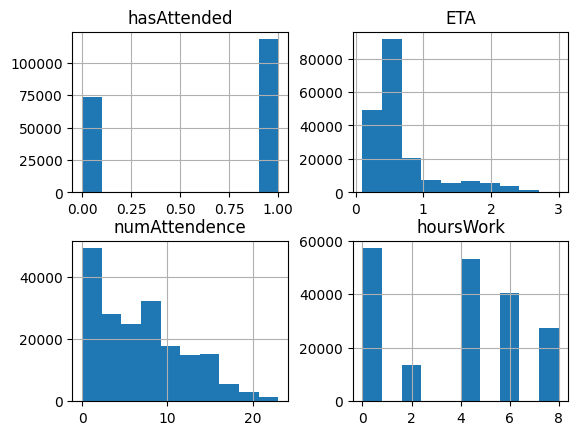

In [12]:
df_attendance[['hasAttended', 'ETA', 'numAttendence', 'hoursWork']].hist()

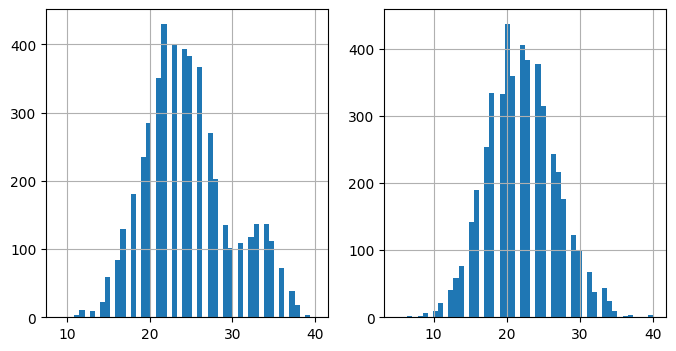

In [13]:
_,axs = plt.subplots(1, 2, figsize=(8,4))
df_group = df_attendance.groupby(by=['course','date'])

n = df_group['hasAttended'].sum().count()
expected = rng.poisson(22, n)
df_group['hasAttended'].sum().hist(bins=50, ax=axs[0])
axs[1].hist(expected, bins=50)
axs[1].grid()

In [14]:
from scipy.stats import chisquare, poisson
from collections import Counter
import math

obs = df_group['hasAttended'].sum().values
f_obs = []
f_exp = []
kvs = sorted([(k,v) for k, v in Counter(obs).items()], key=lambda x: x[0])
for k, v in kvs:
    f_obs.append(v)
    f_exp.append(poisson.pmf(k, 22))
f_obs = np.array(f_obs)
f_exp = np.round(np.array(f_exp)*n)
chisquare(f_obs, f_exp)

Power_divergenceResult(statistic=3261.787423936582, pvalue=0.0)

In [15]:
# the final grade is normally distributed around mean
def sampleGrade(row):
    y = 1.2*np.exp(-0.2*row.hoursWork_mean) - 3.2*np.log(1.5 + row.ETA_mean) + 3.2*np.log(1.2+row.numAttendence_max) - 1.1 * row.numChildren * (1 - row.isSingle) / (1.5 + 0.5*np.exp(0.9*row.age - 30))
    return np.round(np.clip(rng.normal(y, 0.5),0,10), 2)

# aggregate the variables to apply sampleGrade
df = df_attendance.groupby(['course', 'student']).agg({'hoursWork':['mean'], 'ETA':['mean'], 'numAttendence': ['max']})
df.columns = df.columns.map('_'.join)
df = df.reset_index()
df = pd.merge(df, df_students, left_on='student', right_index=True)
df['grade'] = df.apply(sampleGrade, axis=1)
df.to_csv("grade.csv")

print(df[['hoursWork_mean', 'ETA_mean', 'numAttendence_max', 'age', 'numChildren', 'work','isSingle','grade']].describe())

       hoursWork_mean     ETA_mean  numAttendence_max          age  \
count     8000.000000  8000.000000        8000.000000  8000.000000   
mean         3.654927     0.678672          14.180875    29.033250   
std          2.403918     0.237007           4.632909     2.088765   
min          0.000000     0.146089           1.000000    25.000000   
25%          0.000000     0.499656          11.000000    28.000000   
50%          5.000000     0.653385          14.000000    29.000000   
75%          5.333333     0.825771          18.000000    30.000000   
max          6.666667     1.660902          23.000000    37.000000   

       numChildren         work     isSingle        grade  
count  8000.000000  8000.000000  8000.000000  8000.000000  
mean      1.365375     0.701875     0.366625     6.155848  
std       1.466167     0.457463     0.481913     2.042811  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     4.930000  
50%      

<Axes: >

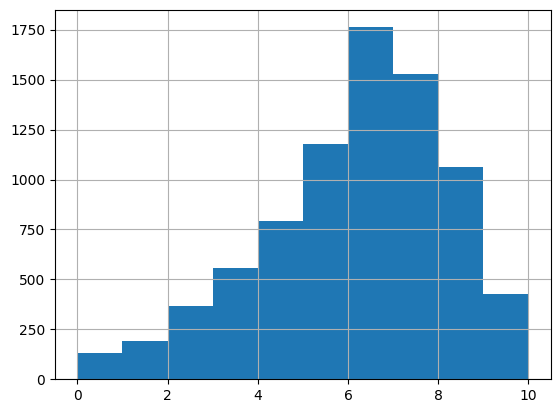

In [16]:
df.grade.hist()

In [38]:
# linear regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LogisticRegression

reg = LinearRegression()
glm_poiss = TweedieRegressor(power=1,max_iter=1000)
logistic = LogisticRegression(max_iter=1000)

In [24]:
grade_x = df[['hoursWork_mean', 'ETA_mean', 'numAttendence_max', 'age', 'numChildren', 'enrollmentTime', 'work', 'isSingle']].values
grade_y = df.grade.values

attendance_cols = ['ETA', 'hasExam', 'numAttendence', 'hoursWork', 'week', 'isSunny', 'isRainy'
                   , 'mmRain', 'age', 'numChildren', 'enrollmentTime', 'work', 'isSingle']
att_dataset = df_attendance.merge(df_days, left_on='date', right_index=True).merge(df_students, left_on='student', right_index=True)
att_x = att_dataset[attendance_cols].values
att_y = att_dataset.hasAttended.values

In [34]:
avg_data = att_dataset.groupby(by=['date', 'course']).mean().reset_index()
sum_data = att_dataset.groupby(by=['date', 'course']).sum().reset_index()
totatt_dataset = sum_data.merge(avg_data, on=['date','course'])

totatt_cols = ['ETA_y', 'hasExam_y', 'numAttendence_y', 'hoursWork_y', 'isSunny_y', 'isRainy_y'
               , 'mmRain_y', 'age_y', 'numChildren_y', 'enrollmentTime_y', 'work_y', 'isSingle_y']
totatt_x = totatt_dataset[totatt_cols].values
totatt_y = totatt_dataset.hasAttended_x.values

In [35]:
reg.fit(grade_x, grade_y).score(grade_x, grade_y)

0.8763391023017916

In [39]:
logistic.fit(att_x, att_y).score(att_x, att_y)

0.780359375

In [40]:
glm_poiss.fit(totatt_x, totatt_y).score(totatt_x, totatt_y)

0.6293118033012409